In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from itertools import product
from scipy.stats import lognorm, norm
from sklearn.linear_model import LinearRegression 



DATA_DIR = Path('../data')
MODEL_DIR = Path('../models')

# Import Datasets

In [2]:
DATA_DIR = Path('../data')

X_train_file = DATA_DIR / 'X-train-from-distribution.npy'
Y_train_file = DATA_DIR / 'Y-train-from-distribution.npy'
X_train = np.load(X_train_file)
Y_train = np.load(Y_train_file)
print(f'Train dataset size: {X_train.shape}')

X_test_file = DATA_DIR / 'X-test-from-distribution.npy'
Y_test_file = DATA_DIR / 'Y-test-from-distribution.npy'
X_test = np.load(X_test_file)
Y_test = np.load(Y_test_file)
print(f'Test dataset size: {X_test.shape}')

Train dataset size: (18000, 15)
Test dataset size: (4500, 15)


In [7]:
lobes = np.array(["alpha'1", "alpha'2", "alpha'3", 'alpha1', 'alpha2', 'alpha3',
       "beta'1", "beta'2", 'beta1', 'beta2', 'gamma1', 'gamma2', 'gamma3',
       'gamma4', 'gamma5'])

greek_lobes = [
    r"$\alpha'_1$", r"$\alpha'_2$", r"$\alpha'_3$", 
    r'$\alpha_1$', r'$\alpha_2$', r'$\alpha_3$', 
    r"$\beta'_1$", r"$\beta'_2$",
    r'$\beta_1$', r'$\beta_2$', 
    r'$\gamma_1$', r'$\gamma_2$', r'$\gamma_3$', r'$\gamma_4$', r'$\gamma_5$'
]

# Linear Fit (one-to-one)

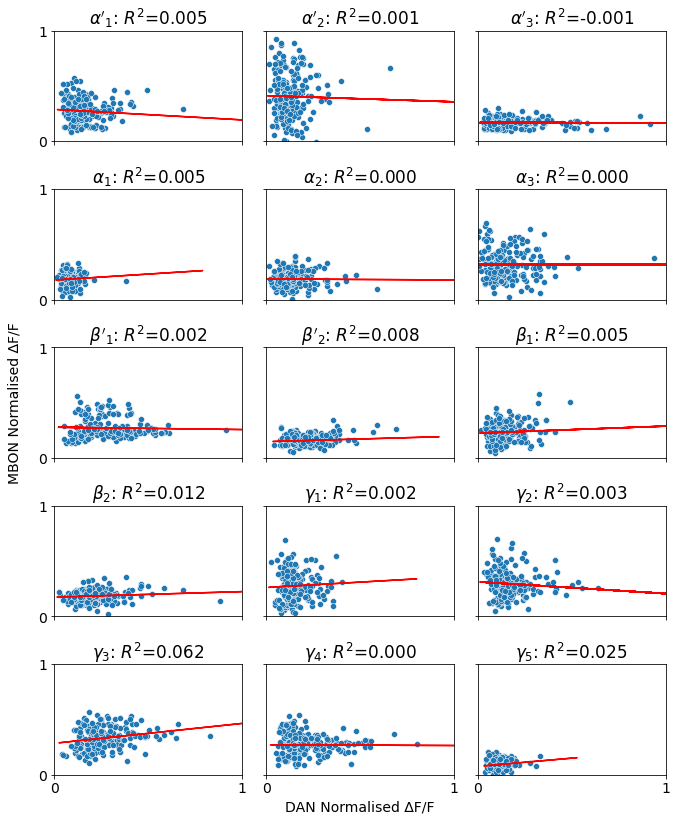

In [15]:
# use the testing data to find R^2 and mse
plt.rcParams["font.size"] = 14

model_parameters = {}
rsquared_canonical = {}
mse_canonical = {}

fig, axes = plt.subplots(5, 3, figsize=(10,12), sharex='all', sharey='all')

for i, lobe in enumerate(lobes):
    
    # fit canonical model  
    x = X_train[:, i]
    y = Y_train[:, i]
    xT = x.reshape((-1,1))
    model = LinearRegression(fit_intercept=True).fit(xT, y)
    
    # score using test set
    gt_x = X_test[:, i]
    gt_y = Y_test[:, i]
    gt_x = gt_x.reshape((-1,1))
    
    y_pred = model.predict(gt_x)
    
    score = model.score(gt_x, gt_y)
    rsquared_canonical[lobe] = score
    mse = np.sum((y_pred - gt_y)**2) / y_pred.size
    mse_canonical[lobe] = mse
    
    model_parameters[lobe] = {
        'm': model.coef_,
        'c': model.intercept_,
        'r2': score
    }
    
    ax = axes[int(i/3), i%3]
    ax.set_title(''.join([greek_lobes[i], r': $R^2$=', f'{score:.3f}']) )
    ax.set_ylim([0,1])
    ax.set_xlim([0,1])

    ax.plot(xT, model.predict(xT), 'r')
    # downsample data for visualisation    
    sns.scatterplot(
        x = x[::90],
        y = y[::90],
        ax=ax
    )
    ax.set_xticks([])

    if i == 0:
        ax.set_yticks([0, 1])

ax.set_xticks([0, 1])

# Add common axis labels
fig.add_subplot(111, frameon=False)  
plt.grid(False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel('DAN Normalised ∆F/F')
plt.ylabel('MBON Normalised ∆F/F')

plt.tight_layout()
plt.savefig('canonical-fit.png', transparent=True)

In [5]:
# Check that the Score is implemented using the standard R-squared algorithm

# total sum of squares: remove mean, square and sum
tss = np.sum((gt_y - gt_y.mean())**2)

# risidual sum of squares or the sum of residual errors
rss = np.sum((gt_y - y_pred)**2)

assert (1 - rss / tss) == score

In [54]:
tss

8.259257234310809

In [33]:
def plot_matrix(matrix, labels, title, cbar_title=None, size=[8,8], switch=False):
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(matrix)
    
    plt.yticks(range(len(labels)), labels)
    plt.xticks(range(len(labels)), labels)
    plt.title(title)
    
    ax.set_ylim(14.5, -0.5)
    
    if switch:
        plt.xlabel('Target', fontsize=16)
        plt.ylabel('Source', fontsize=16)
    else:
        plt.xlabel('Source', fontsize=16)
        plt.ylabel('Target', fontsize=16)
    # Loop over data dimensions and create text annotations.
    for i in range(len(labels)):
        for j in range(len(labels)):
            col = 'white' if matrix[i, j] < matrix.max()/2 else 'black'
            text = ax.text(j, i, int(matrix[i, j]),
                           ha="center", va="center", color=col)

    # Create colorbar
    if cbar_title is not None:
        cbar = ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel(cbar_title, rotation=-90, va="bottom", fontsize=16)

    plt.tight_layout()

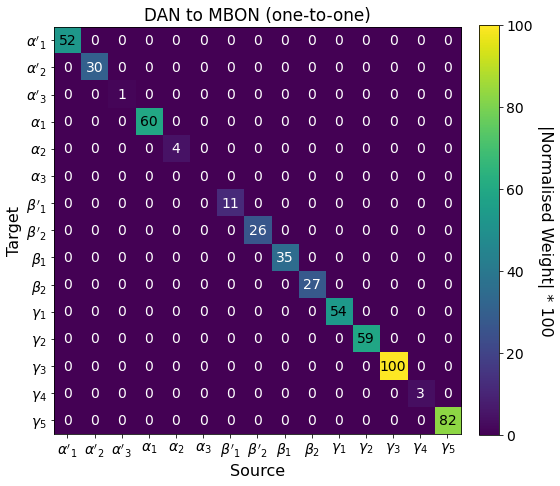

In [41]:

Wxh = np.zeros([15,15])
for i, lobe in enumerate(lobes):
    # weighting of connections for all DAN lobes to single MBON:lobe=lobe
    weight = model_parameters[lobe]['m']
    Wxh[i,i] = weight


M = np.abs(Wxh)
greek_lobes = [r"$\alpha '_1$", r"$\alpha '_2$", r"$\alpha '_3$", 
              r"$\alpha _1$", r"$\alpha _2$", r"$\alpha_3$",
              r"$\beta '_1$", r"$\beta '_2$", r"$\beta _1$", r"$\beta _2$",
              r"$\gamma _1$", r"$\gamma _2$", r"$\gamma _3$", r"$\gamma _4$", r"$\gamma _5$", ]

plot_matrix(
    M / M.max() * 100, 
    greek_lobes, 
    'DAN to MBON (one-to-one)', 
    '|Normalised Weight| * 100',
    switch=False
)

plt.savefig('weights-dan-to-mbon-canonical.png')

In [36]:
print(f'Mean score (R squared): {np.mean(list(rsquared_canonical.values()))}')

Mean score (R squared): 0.008606598895064115


In [37]:
print(f'Mean mse : {np.mean(list(mse_canonical.values()))}')

Mean mse : 0.010724306595985172


In [38]:
RESULTS_DIR = Path('../results')

file_name = 'canonical_linear_model_testing_data_rsquared.json'

with open( RESULTS_DIR / file_name, "w") as score_file:
    json.dump(rsquared_canonical, score_file, indent='\t')
    
file_name = 'canonical_linear_model_testing_data_mse.json'

with open( RESULTS_DIR / file_name, "w") as mse_file:
    json.dump(mse_canonical, mse_file, indent='\t')

## Linear Model (Cross Talk)

In [24]:
# Fit each of the lobes seperately
models = []
rsquared_crossed = {}
mse_crossed = {}

for i, lobe in enumerate(lobes):
    y = Y_train[:,i]
    gt_y = Y_test[:,i]
    model = LinearRegression(fit_intercept=True).fit(X_train, y)

    y_pred = model.predict(X_test)
    score = model.score(X_test, gt_y)
    print(f'score for {lobe}: {score}')
    mse = np.sum((y_pred - gt_y)**2) / y_pred.size

    models.append(model)
    rsquared_crossed[lobe] = score
    mse_crossed[lobe] = mse

print(f'Average score: {np.mean(list(rsquared_crossed.values()))}')


score for alpha'1: 0.09177337039130218
score for alpha'2: 0.09490119073090486
score for alpha'3: 0.09205270634027296
score for alpha1: 0.05185976092034672
score for alpha2: 0.06513177665917269
score for alpha3: 0.07840388669805154
score for beta'1: 0.16209165548132376
score for beta'2: 0.04871437500633735
score for beta1: 0.08832825033962854
score for beta2: 0.04105404428880188
score for gamma1: 0.18503514168200508
score for gamma2: 0.08284445324461653
score for gamma3: 0.1423162592618783
score for gamma4: 0.19937202535269405
score for gamma5: 0.04117124490870816
Average score: 0.09767000942040299


In [25]:
# Check that the Score is implemented using the standard R-squared algorithm

# total sum of squares: remove mean, square and sum
tss = np.sum((gt_y - gt_y.mean())**2)

# risidual sum of squares or the sum of residual errors
rss = np.sum((gt_y - y_pred)**2)

assert (1 - rss / tss) == score

In [26]:
tss

8.259257234310809

In [30]:
file_name = 'crossed_linear_model_testing_data_rsquared.json'

with open( RESULTS_DIR / file_name, "w") as score_file:
    json.dump(rsquared_crossed, score_file, indent='\t')

In [31]:
file_name = 'crossed_linear_model_testing_data_mse.json'

with open( RESULTS_DIR / file_name, "w") as mse_file:
    json.dump(mse_crossed, mse_file, indent='\t')

print(f'Mean mse : {np.mean(list(mse_crossed.values()))}')

Mean mse : 0.009613243862876427


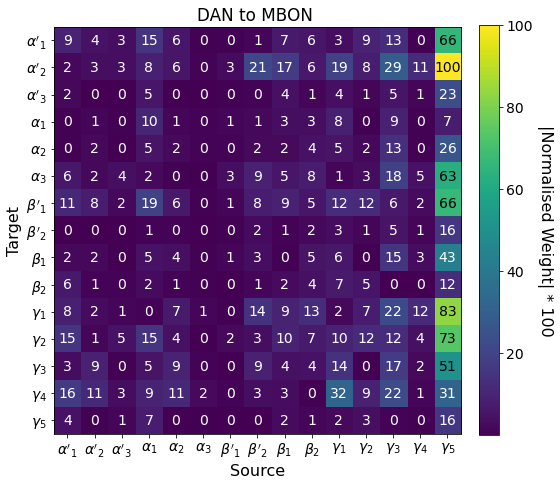

In [40]:
Wxh = np.zeros([15,15])
for i, lobe in enumerate(lobes):
    # weighting of connections for all DAN lobes to single MBON:lobe=lobe
    Wxh[i,:] = models[i].coef_

    
M = np.abs(Wxh)

plot_matrix(
    M / M.max() * 100, 
    greek_lobes, 
    'DAN to MBON ', 
    '|Normalised Weight| * 100',
    switch=False
)

plt.savefig('weights-dan-to-mbon-cross-talk.png')    


# Check R^2 values

In [51]:
with open( RESULTS_DIR / 'canonical_linear_model_testing_data_rsquared.json', "r") as score_file:
    score_canonical = json.load(score_file)

with open( RESULTS_DIR / 'crossed_linear_model_testing_data_rsquared.json', "r") as score_file:
    score_crossed = json.load(score_file)

In [52]:
score_df = pd.concat(
    [pd.Series(score_canonical, name='canonical score'), 
    pd.Series(score_crossed, name='crossed score') ],
    axis=1
)

# Basic stats
score_df.describe()

,canonical score,crossed score
count,15.000000,15.000000
mean,0.008607,0.097670
std,0.016126,0.051286
min,-0.001425,0.041054
25%,0.000645,0.058496
50%,0.003183,0.088328
75%,0.006583,0.118609
max,0.061727,0.199372


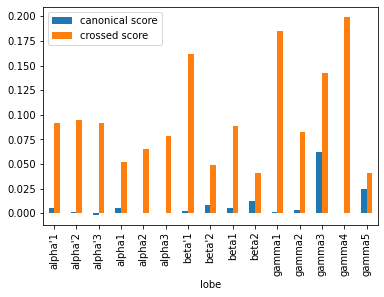

In [20]:
# Visual comparison

score_df["lobe"] = score_df.index
score_df.plot(x="lobe", y=["canonical score", "crossed score"], kind="bar")
plt.show()

# Compare MSE

In [21]:
RESULTS_DIR = Path('../results')

with open( RESULTS_DIR / 'canonical_linear_model_testing_data_mse.json', "r") as file:
    mse_canonical = json.load(file)

with open( RESULTS_DIR / 'crossed_linear_model_testing_data_mse.json', "r") as file:
    mse_crossed = json.load(file)
    
mse_df = pd.concat(
    [pd.Series(mse_canonical, name='canonical mse'), 
    pd.Series(mse_crossed, name='crossed mse') ],
    axis=1
)

mse_df.describe()

,canonical mse,crossed mse
count,15.000000,15.000000
mean,0.010724,0.009613
std,0.011561,0.010431
min,0.001789,0.001702
25%,0.003226,0.003102
50%,0.007856,0.006767
75%,0.014011,0.012247
max,0.046932,0.042517


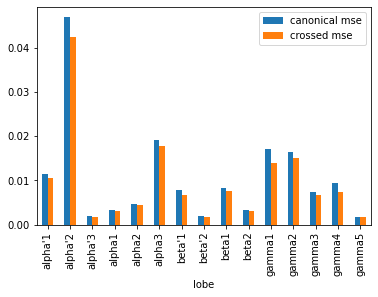

In [22]:
# Visual comparison

mse_df["lobe"] = mse_df.index
mse_df.plot(x="lobe", y=["canonical mse", "crossed mse"], kind="bar")
plt.show()

In [34]:
mse_df

NameError: name 'mse_df' is not defined

In [35]:
tss

8.259257234310809